In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import importlib
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import clear_output
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import random

#Machine learning related imports
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Lambda, Input, Dropout
from sklearn.metrics import mean_squared_error

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Ensure deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(seed)

# Import the data

In [2]:
#Import the data
df= pd.read_csv('D:\\sih project\\dataset\\kalimati_tarkari_dataset.csv')
weather_df = pd.read_csv('D:\\sih project\\dataset\\Nepal_Terai_2013-2021.csv')

# Exploratory Data Analysis
Inspect the data by viewing the basic statistics, missing values and plots.

In [26]:
# Display the first few rows of the dataset
df.tail()

# Display basic information about the dataset


,SN,Commodity,Unit,Minimum,Maximum,Average
Date,,,,,,
2021-05-13,197156,Garlic Dry Nepali,Kg,100.0,120.0,110.0
2021-05-13,197157,Fish Fresh(Rahu),KG,270.0,280.0,275.0
2021-05-13,197158,Fish Fresh(Bachuwa),KG,225.0,235.0,230.0
2021-05-13,197159,Fish Fresh(Chhadi),KG,220.0,230.0,225.0
2021-05-13,197160,Fish Fresh(Mungari),KG,240.0,250.0,245.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 197161 entries, 2013-06-16 to 2021-05-13
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   SN         197161 non-null  int64  
 1   Commodity  197161 non-null  object 
 2   Unit       197161 non-null  object 
 3   Minimum    197161 non-null  float64
 4   Maximum    197161 non-null  float64
 5   Average    197161 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 10.5+ MB


Understand the Data Structure and check for missing values

In [4]:
# Display column names
print("Column Names:", df.columns)

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# How many unique commodities are there?

print('unique commodities: ',df['Commodity'].nunique())

Column Names: Index(['SN', 'Commodity', 'Date', 'Unit', 'Minimum', 'Maximum', 'Average'], dtype='object')
Missing Values:
 SN           0
Commodity    0
Date         0
Unit         0
Minimum      0
Maximum      0
Average      0
dtype: int64
unique commodities:  132


All of the 132 vegetable commodities are contained in the 'Commodity' column. We'll need to turn these into features themselves.

In [5]:
# Check if the data is of a consistent dtype in each column
# Function to check if all values in each column have the same dtype
def check_column_dtypes(df):
    consistent_dtypes = {}
    for col in df.columns:
        # Get the unique data types of the column
        unique_dtypes = df[col].map(type).unique()
        # Check if there is only one unique dtype
        consistent_dtypes[col] = len(unique_dtypes) == 1
    return consistent_dtypes

check_column_dtypes(df)

{'SN': True,
 'Commodity': True,
 'Date': True,
 'Unit': True,
 'Minimum': True,
 'Maximum': True,
 'Average': True}

In [6]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

Plot three commodities (at a time) and loop over all to inspect the time series data for missing values. Nice way to visually inspect the data

In [28]:
# Method to plot n commodites on one graph. Useful beyond just this instance
def plot_n_commodities(df, n, m):
    # Get the first n unique commodities
    unique_commodities = df['Commodity'].unique()[n:m]

    # Filter the DataFrame for the selected commodities
    df_filtered = df[df['Commodity'].isin(unique_commodities)].drop(columns=['SN', 'Minimum', 'Maximum'])

    # Create a new figure with the specified size
    plt.figure(figsize=(7.5, 5))

    # Plot time series data for each of the selected commodities on the same graph
    for commodity in unique_commodities:
        commodity_data = df_filtered[df_filtered['Commodity'] == commodity]
        plt.plot( commodity_data['Average'], label=commodity)  # Assuming 'Date' is the x-axis

    plt.title(f'Time Series of Prices for Commodities {n} to {m}')
    plt.ylabel('Price')
    plt.legend(loc='best')
    plt.show()


# Feature Engineering
* Pivot the dataframe in order to create average price features for each commodity
* Drop High and Low columns

In [8]:
# Pivot the dataframe to have dates as rows and commodities as columns with average prices
pivot_df = df.pivot_table(index='Date', columns='Commodity', values='Average')

# Reset the index to make 'Date' column
pivot_df.reset_index(inplace=True)

pivot_df.head()

Commodity,Date,Apple(Fuji),Apple(Jholey),Arum,Asparagus,Bakula,Bamboo Shoot,Banana,Barela,Bauhania flower,...,Tomato Big(Nepali),Tomato Small(Indian),Tomato Small(Local),Tomato Small(Terai),Tomato Small(Tunnel),Turnip,Turnip A,Water Melon(Dotted),Water Melon(Green),Yam
0,2013-06-16,NaN,110.0,NaN,125.0,NaN,55.0,75.0,NaN,NaN,...,37.5,NaN,29.0,NaN,NaN,47.5,42.5,NaN,16.5,NaN
1,2013-06-17,NaN,120.0,NaN,125.0,NaN,55.0,75.0,NaN,NaN,...,27.5,NaN,22.5,NaN,NaN,NaN,47.5,NaN,15.0,NaN
2,2013-06-18,NaN,115.0,NaN,110.0,NaN,55.0,75.0,NaN,NaN,...,27.5,NaN,24.0,NaN,NaN,47.5,47.5,NaN,13.5,NaN
3,2013-06-19,NaN,115.0,NaN,112.5,NaN,55.0,75.0,NaN,NaN,...,27.5,NaN,26.0,NaN,NaN,47.5,47.5,NaN,15.0,NaN
4,2013-06-20,NaN,115.0,NaN,110.0,NaN,55.0,75.0,NaN,NaN,...,27.5,NaN,24.0,NaN,NaN,42.5,55.0,NaN,15.0,NaN


Work out the extent to which commodities are missing data

In [9]:
entries = {}
for col in pivot_df.columns:
    if col != 'Date':
        entries[col] = pivot_df[col].notna().sum()# Sort the dictionary by values in descending order
        
sorted_entries = dict(sorted(entries.items(), key=lambda item: item[1], reverse=True))

# Drop the commodoties with fewer than 2700 entries 
# (by inspection, the index for the last commodity having 2700 entries is 13)

In [10]:
pivot_df.drop(columns=list(sorted_entries.keys())[13:],inplace=True)
pivot_df.set_index('Date', inplace=True)

Check for the vegetable dataset, are there any missing days? We can check this by using the resample() method. This will also ensure that there will be no duplicated dates after the resampling.

In [11]:
pivot_df = pivot_df.resample('D').asfreq()

What's the new length after resampling?

In [12]:
len(pivot_df.index)

2889

We can see that the Date index has increased in length from 2753 to 2889. Therefore, there were 136 missing days in the date column. Let us impute the data using a linear interpoloation. This has the best chance of capturing the overall evolution of price during the missing dates.

In [13]:
pivot_df.interpolate(method='linear',inplace=True)

After interpolating, have we now got a complete dataset?

In [14]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2889 entries, 2013-06-16 to 2021-05-13
Freq: D
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Bamboo Shoot          2889 non-null   float64
 1   Banana                2889 non-null   float64
 2   Brd Leaf Mustard      2889 non-null   float64
 3   Cabbage(Local)        2889 non-null   float64
 4   Cauli Local           2889 non-null   float64
 5   Chilli Dry            2889 non-null   float64
 6   Coriander Green       2889 non-null   float64
 7   French Bean(Local)    2889 non-null   float64
 8   Ginger                2889 non-null   float64
 9   Onion Dry (Indian)    2889 non-null   float64
 10  Potato Red            2889 non-null   float64
 11  Raddish White(Local)  2889 non-null   float64
 12  Tomato Small(Local)   2889 non-null   float64
dtypes: float64(13)
memory usage: 316.0 KB


yes!

# Combine Meteorological features Data
Parameter(s):
T2M MERRA-2 Temperature at 2 Meters (C)
TS MERRA-2 Earth Skin Temperature (C)
ALLSKY_SFC_LW_DWN CERES SYN1deg All Sky Surface Longwave Downward Irradiance (W/m^2)
PRECTOTCORR MERRA-2 Precipitation Corrected (mm/day)
QV2M MERRA-2 Specific Humidity at 2 Meters (g/kg)
WS2M MERRA-2 Wind Speed at 2 Meters (m/s)
CLRSKY_SFC_PAR_TOT CERES SYN1deg Clear Sky Surface PAR Total (W/m^2) (Clear Sky Surface Photosynthetically Active Radiation (PAR) Total)

In [15]:
weather_df.head()
# Convert YEAR and day of year (DOY) to a Date column in the weather dataset
weather_df['Date'] = pd.to_datetime(weather_df['YEAR'].astype(str) + '-' + weather_df['DOY'].astype(str), format='%Y-%j')
weather_df.drop(columns=['YEAR','DOY'],inplace=True)
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

In [16]:
# Merge the datasets on the Date column
combined_df = pd.merge(pivot_df, weather_df, on='Date', how='inner')
combined_df.set_index('Date',inplace=True)

# Inspect the combined dataframe
Are there any missing days in the data?

In [17]:
# Method to plot and check that there are no visually obvious errors in the dataframe values after imputation and combining dataframes
def plot_features(df, n, m):
    # Get the first n unique commodities

    # Create a new figure with the specified size
    plt.figure(figsize=(7.5, 5))

    # Plot time series data for each of the selected commodities on the same graph
    for feature in df.columns[n:m]:
        plt.plot( df[feature], label=feature)  # Assuming 'Date' is the x-axis

    plt.title(f'Time Series of values of features {n} to {m}')
    plt.ylabel('value')
    plt.legend(loc='best')
    plt.show()

# Create TimeseriesGenerator() data to pass into the model

In [18]:
features = combined_df[list(combined_df.columns[-7:])].copy()
features['Potato Red'] = combined_df['Potato Red']
features.info()
target = combined_df['Potato Red'].copy()

# Next, perform scaling:

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
features_scaled = scaler_x.fit_transform(features)
target_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1))

# Define time steps
time_steps = 20

# Split the data into training and testing sets
train_size = int(len(features_scaled) * 0.8)
val_size = int(train_size*0.2)

train_features = features_scaled[:train_size-val_size]
train_target = target_scaled[:train_size-val_size]

val_features = features_scaled[train_size-val_size:train_size]
val_target = target_scaled[train_size-val_size:train_size]

test_features = features_scaled[train_size:]
test_target = target_scaled[train_size:]

# Append the last part of the training set to the beginning of the test set
append_length = time_steps
test_features = np.vstack([train_features[-append_length:], test_features])
test_target = np.vstack([train_target[-append_length:], test_target])
# Create TimeseriesGenerator instances
batch_size = 25
train_generator = TimeseriesGenerator(train_features, train_target, length=time_steps, batch_size=batch_size)
val_generator = TimeseriesGenerator(val_features, val_target, length=time_steps, batch_size=batch_size)
test_generator = TimeseriesGenerator(test_features, test_target, length=time_steps, batch_size=batch_size)

# Check the generators
print(f"Number of training samples: {len(train_generator)}")
print(f"Number of validation samples: {len(val_generator)}")
print(f"Number of testing samples: {len(test_generator)}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2889 entries, 2013-06-16 to 2021-05-13
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   T2M                 2889 non-null   float64
 1   TS                  2889 non-null   float64
 2   ALLSKY_SFC_LW_DWN   2889 non-null   float64
 3   PRECTOTCORR         2889 non-null   float64
 4   QV2M                2889 non-null   float64
 5   WS2M                2889 non-null   float64
 6   CLRSKY_SFC_PAR_TOT  2889 non-null   float64
 7   Potato Red          2889 non-null   float64
dtypes: float64(8)
memory usage: 203.1 KB
Number of training samples: 74
Number of validation samples: 18
Number of testing samples: 24


# LSTM Model Setup

In [19]:
%%time
# Clear any previous session to keep consistency 
tf.keras.backend.clear_session()

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Define the model architecture
model = Sequential([
    # Input layer specifying the shape of the input data
    Input(shape=(time_steps, train_features.shape[1])),
    
    # First Bidirectional LSTM layer with 32 units, returning sequences
    Bidirectional(LSTM(32, return_sequences=True)),
    
    # Dropout layer to prevent overfitting
    Dropout(0.01),
    
    # Second Bidirectional LSTM layer with 32 units and L2 regularization
    Bidirectional(LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(1e-4))),
    
    # Dense layer with 1 unit to output the prediction
    Dense(1),
    
    # Lambda layer to scale the output by 100.0
    Lambda(lambda x: x * 100.0)
])

# Compile the model with Adam optimizer and Huber loss
model.compile(optimizer=Adam(learning_rate=5e-4), loss=Huber())

# Define EarlyStopping callback to monitor validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',           # Metric to monitor
    patience=20,                  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True     # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model
history = model.fit(
    train_generator,              # Training data generator
    epochs=150,                   # Number of epochs to train
    validation_data=val_generator,# Validation data generator
    callbacks=[early_stopping],   # Early stopping callback
    verbose=False                 # Verbose mode
)

# Make predictions on the test data
pred = model.predict(test_generator)

# Inverse transform the predictions to get the original scale
pred = scaler_y.inverse_transform(pred)

# Inverse transform the true test target values to get the original scale
test_true = scaler_y.inverse_transform(test_target)

# Calculate mean squared error between the true and predicted test values
mse = mean_squared_error(test_true[time_steps:], pred)
print(time_steps,mse)


c:\Users\gedda\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
20 241.20624975813024
CPU times: total: 16.9 s
Wall time: 58.7 s


In [20]:
%%time
mse = mean_squared_error(test_true[time_steps:], pred)
print(time_steps,mse)

20 241.20624975813024
CPU times: total: 0 ns
Wall time: 1.01 ms


# Run a loop to evaluate the impact of varying hyperparameters

In [21]:
MSE_array = []
history_array = []
Output = {}
paramter_variation = [0.0001,0.001,0.01,0.1,0.5,0.75]

# Vary this - 150 used for the report
epochs = 50



for i in paramter_variation:
    #----------------------------------- Model Setup ------------------------------------#
    # Clear any existing models and sessions - for reproducibility
    tf.keras.backend.clear_session()

    # Set seeds for reproducibility
    seed = 42
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

    model = Sequential([
        Input(shape=(time_steps, train_features.shape[1])),
        Bidirectional(LSTM(32, return_sequences=True),),
        Dropout(i),
        Bidirectional(LSTM(32,kernel_regularizer=tf.keras.regularizers.l2(1e-4))),
        Dense(1),
        Lambda(lambda x: x * 100.0)
    ])

    # Save the initial weights (only needed once)
    initial_weights_path = r'/kaggle/working/initial_weights.weights.h5'
    #model.save_weights(initial_weights_path)
   # model.load_weights(initial_weights_path)

    # --------------------------------- Compile and fit the model ---------------------- #


    model.compile(optimizer=Adam(learning_rate=5e-4), loss=Huber())

    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor
        patience=20,          # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
    )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stopping],
        verbose=False
    )

    pred = model.predict(test_generator)
    pred = scaler_y.inverse_transform(pred)
    test_true = scaler_y.inverse_transform(test_target)
    
    history_array.append(history)
    mse= mean_squared_error(test_true[20:], pred)
    
    MSE_array.append(mse)
    Output[str(i)]=mse
    print(i)
    
print(MSE_array)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
0.0001
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
0.001
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
0.01
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
0.1
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
0.5
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
0.75
[137.90501576731123, 267.9194426224765, 241.20624975813024, 209.91486145575854, 121.69594753936948, 190.1579169284687]


In [22]:
# To 2 decimal places
formatted_array = [f"{x:.2f}" for x in MSE_array]
print(formatted_array)

['137.91', '267.92', '241.21', '209.91', '121.70', '190.16']


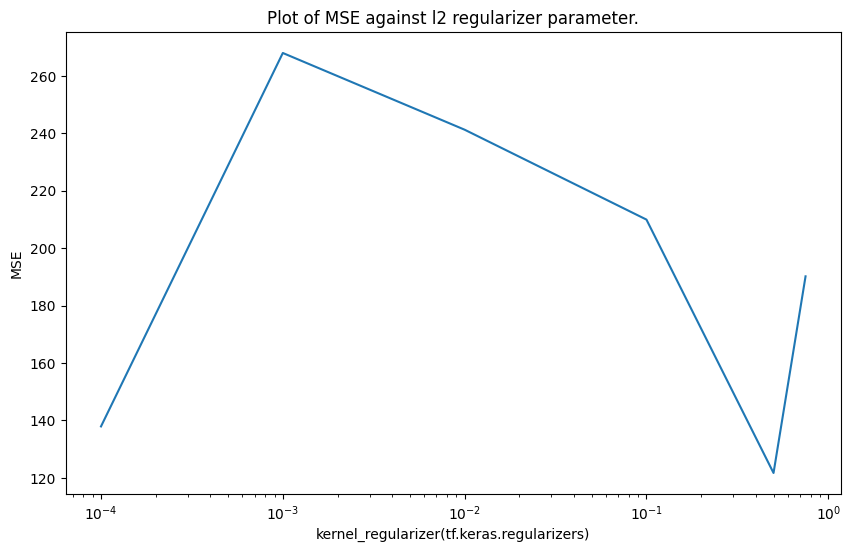

In [23]:
plt.figure(figsize=(10,6))
plt.semilogx(paramter_variation,MSE_array)
plt.xlabel('kernel_regularizer(tf.keras.regularizers)')
plt.ylabel('MSE')
plt.title('Plot of MSE against l2 regularizer parameter.')
plt.show()

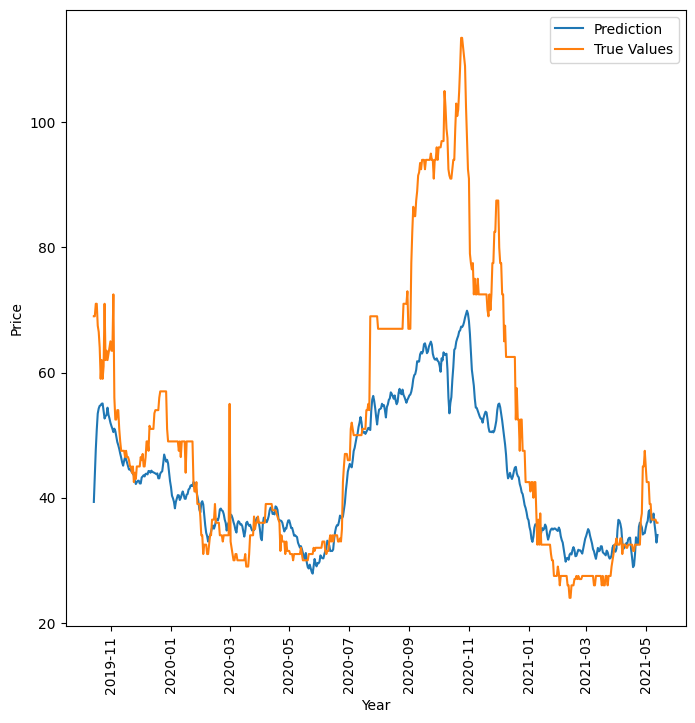

In [24]:
# Extract the test data timestamps (starting from train_size)
timestamps = combined_df.index[train_size:]

# Extract only the dates from the timestamps
dates_only = [timestamp.date() for timestamp in timestamps]

plt.figure(figsize=(8,8))
plt.plot(dates_only,pred,label='Prediction')
plt.plot(dates_only,test_true[20:],label='True Values')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.legend()

In [29]:
import pickle

# Save the model to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)